In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import re
import os
import os.path as osp
import sys
import time
import glob
import cv2
from tqdm import tqdm, tnrange, tqdm_notebook
from collections import OrderedDict
import PIL
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split, Subset

import torchvision
from torchvision import transforms, datasets, models

from mpl_toolkits.axes_grid1 import ImageGrid

from dataset import COCODataset
from dataset import variable_shape_collate_fn

import utils
from utils import load_image, postprocessing, \
                  bbox_x1y1x2y2_to_xywh, bbox_x1y1x2y2_to_cxcywh, bbox_cxcywh_to_x1y1x2y2, bbox_cxcywh_to_xywh
from draw import draw_outline, draw_rect, draw_text, show_grid, show_img


# Download COCO dataset

Run "get_coco_dataset.sh" to download the training data if you haven't already

In [2]:
#Uncomment to run bash script
#!./data/get_coco_dataset.sh

In [3]:
def load_coco(path):
    with open(path) as f:
        return [line.rstrip("\n") for line in f.readlines()]

In [4]:
coco_path = './coco.names'
classes_names = load_coco(coco_path)

# Paths

In [5]:
CUDA = True
use_cuda = True
weight_path = './yolov3.weights'
backbone_weight_path = './darknet53.conv.74'
coco_path = './data/coco.names'
train_target_txt = "./data/coco/trainvalno5k.txt"
valid_target_txt = "./data/coco/5k.txt"

# Build target tensor to train against

## Multi box IOU calcuation

In [6]:
# mode - x1y1x2y2, cxcywh
def bbox_iou(b1, b2, mode="x1y1x2y2"):
    #num_box = bbox.shape[0]
    
    if mode == "x1y1x2y2":
        b1_x1, b1_y1, b1_x2, b1_y2 = b1[...,0], b1[...,1], b1[...,2], b1[...,3]
        b2_x1, b2_y1, b2_x2, b2_y2 = b2[...,0], b2[...,1], b2[...,2], b2[...,3]  
    elif mode == "cxcywh":
        b1_x1, b1_x2 = b1[..., 0] - b1[..., 2] / 2, b1[..., 0] + b1[..., 2] / 2
        b1_y1, b1_y2 = b1[..., 1] - b1[..., 3] / 2, b1[..., 1] + b1[..., 3] / 2
        b2_x1, b2_x2 = b2[..., 0] - b2[..., 2] / 2, b2[..., 0] + b2[..., 2] / 2
        b2_y1, b2_y2 = b2[..., 1] - b2[..., 3] / 2, b2[..., 1] + b2[..., 3] / 2
    
    num_b1 = b1.shape[0]
    num_b2 = b2.shape[0]
    
    inter_x1 = torch.max(b1_x1.unsqueeze(1).repeat(1, num_b2), b2_x1)
    inter_y1 = torch.max(b1_y1.unsqueeze(1).repeat(1, num_b2), b2_y1)
    inter_x2 = torch.min(b1_x2.unsqueeze(1).repeat(1, num_b2), b2_x2)
    inter_y2 = torch.min(b1_y2.unsqueeze(1).repeat(1, num_b2), b2_y2)
            
    inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * torch.clamp(inter_y2 - inter_y1, min=0)
    b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    b2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)
    union_area = b1_area.unsqueeze(1).repeat(1, num_b2) + b2_area.unsqueeze(0).repeat(num_b1, 1) - inter_area
    
    iou = inter_area / union_area
    return iou

## Yolo Loss layer

In [7]:
class YoloLayer(nn.Module):
    def __init__(self, anchors, img_dim, numClass):
        super().__init__()
        self.anchors = anchors
        self.img_dim = img_dim
                
        self.numClass = numClass
        self.bbox_attrib = 5 + numClass
        
        
        self.lambda_xy = 2.5
        self.lambda_wh = 2.5
        self.lambda_conf = 1 #1.0
        self.lambda_cls = 1 #1.0
        
        self.obj_scale = 1 #5
        self.noobj_scale = 0.5 #1
        
        self.ignore_thres = 0.5
        
        self.mseloss = nn.MSELoss()
        self.bceloss = nn.BCELoss()
        
        self.training = False
 
    def forward(self, x, target=None):
        #x : bs x nA*(5 + num_classes) * h * w
        nB = x.shape[0]
        nA = len(self.anchors)
        nH, nW = x.shape[2], x.shape[3]
        stride = self.img_dim[0] / nH
        anchors = torch.FloatTensor(self.anchors) / stride
        
        #Reshape predictions from [B x [A * (5 + numClass)] x H x W] to [B x A x H x W x (5 + numClass)]
        preds = x.view(nB, nA, self.bbox_attrib, nH, nW).permute(0, 1, 3, 4, 2).contiguous()
        
        # tx, ty, tw, wh
        preds_xy = preds[..., :2].sigmoid()
        preds_wh = preds[..., 2:4]
        preds_conf = preds[..., 4].sigmoid()
        preds_cls = preds[..., 5:].sigmoid()
        
        # Calculate cx, cy, anchor mesh
        mesh_x = torch.arange(nW).repeat(nW,1).unsqueeze(2)
        mesh_y = torch.arange(nH).repeat(nH,1).t().unsqueeze(2)
        mesh_xy = torch.cat((mesh_x,mesh_y), 2)
        mesh_anchors = anchors.view(1, nA, 1, 1, 2).repeat(1, 1, nH, nW, 1)
        
        # pred_boxes holds bx,by,bw,bh
        pred_boxes = torch.FloatTensor(preds[..., :4].shape)
        pred_boxes[..., :2] = preds_xy.cpu().detach() + mesh_xy # sig(tx) + cx
        pred_boxes[..., 2:4] = preds_wh.cpu().detach().exp() * mesh_anchors  # exp(tw) * anchor
        
        if target is not None:
            obj_mask, noobj_mask, tconf, tcls, tx, ty, tw, th, nCorrect, nGT = self.build_target_tensor(
                                                                    pred_boxes, target.cpu(), anchors, (nH, nW), self.numClass,
                                                                    self.ignore_thres)
            
            recall = float(nCorrect / nGT) if nGT else 1
            
            # masks for loss calculations
            obj_mask, noobj_mask = obj_mask.cuda(), noobj_mask.cuda()
            cls_mask = (obj_mask == 1)
            tconf, tcls = tconf.cuda(), tcls.cuda()
            tx, ty, tw, th = tx.cuda(), ty.cuda(), tw.cuda(), th.cuda()

            loss_x = self.lambda_xy * self.bceloss(preds_xy[..., 0] * obj_mask, tx * obj_mask)
            loss_y = self.lambda_xy * self.bceloss(preds_xy[..., 1] * obj_mask, ty * obj_mask)
            loss_w = self.lambda_wh * self.mseloss(preds_wh[..., 0] * obj_mask, tw * obj_mask) / 2
            loss_h = self.lambda_wh * self.mseloss(preds_wh[..., 1] * obj_mask, th * obj_mask) / 2
            loss_conf = self.lambda_conf * \
                        ( self.obj_scale * self.bceloss(preds_conf * obj_mask, obj_mask) + \
                          self.noobj_scale * self.bceloss(preds_conf * noobj_mask, noobj_mask * 0) )
            loss_cls = self.lambda_cls * self.bceloss(preds_cls[cls_mask], tcls[cls_mask])
            loss =  loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls
                
            return loss, loss.item(), loss_x.item(), loss_y.item(), loss_w.item(), loss_h.item(), \
                   loss_conf.item(), loss_cls.item(), \
                   nCorrect, nGT
           
        # Return predictions if not training 
        out = torch.cat((pred_boxes.cuda() * stride, 
                         preds_conf.cuda().unsqueeze(4),
                         preds_cls.cuda() ), 4)
        
        # Reshape predictions from [B x A x H x W x (5 + numClass)] to [B x [A x H x W] x (5 + numClass)]
        # such that predictions at different stride could concatenated on same dimension
        out = out.permute(0, 2, 3, 1, 4).contiguous().view(nB, nA*nH*nW, self.bbox_attrib)
        return out

    def build_target_tensor(self, preds, target, anchors, inp_dim, numClass, ignore_thres):
        nB = target.shape[0]
        nA = len(anchors)
        nH, nW = inp_dim[0], inp_dim[1]
        nCorrect = 0
        nGT = 0
        target = target.float()

        obj_mask = torch.zeros(nB, nA, nH, nW, requires_grad=False)
        noobj_mask = torch.ones(nB, nA, nH, nW, requires_grad=False)
        tconf= torch.zeros(nB, nA, nH, nW, requires_grad=False)
        tcls= torch.zeros(nB, nA, nH, nW, numClass, requires_grad=False)
        tx = torch.zeros(nB, nA, nH, nW, requires_grad=False)
        ty = torch.zeros(nB, nA, nH, nW, requires_grad=False)
        tw = torch.zeros(nB, nA, nH, nW, requires_grad=False)
        th = torch.zeros(nB, nA, nH, nW, requires_grad=False)

        for b in range(nB):
            for t in range(target.shape[1]):
                if target[b, t].sum() == 0:
                    break;
                nGT += 1

                gx = target[b, t, 1] * nW
                gy = target[b, t, 2] * nH
                gw = target[b, t, 3] * nW
                gh = target[b, t, 4] * nH
                gi = int(gx)
                gj = int(gy)

                #preds - [bs x A x W x H x (5+C)]  
                tmp_gt_boxes = torch.FloatTensor([gx, gy, gw, gh])
                tmp_pred_boxes = preds[b].view(-1, 4)
                tmp_ious, _ = torch.max(bbox_iou(tmp_pred_boxes, tmp_gt_boxes, mode="cxcywh"), 1)
                ignore_idx = (tmp_ious > ignore_thres).view(nA, nH, nW)
                noobj_mask[b][ignore_idx] = 0
                
                #find best fit anchor for each ground truth box
                tmp_gt_boxes = torch.FloatTensor([[0, 0, gw, gh]])
                tmp_anchor_boxes = torch.cat((torch.zeros(nA, 2), anchors), 1)
                tmp_ious = bbox_iou(tmp_anchor_boxes, tmp_gt_boxes, mode="cxcywh")
                best_anchor = torch.argmax(tmp_ious, 0).item()
                
                #find iou for best fit anchor prediction box against the ground truth box
                tmp_gt_box = torch.FloatTensor([gx, gy, gw, gh]).unsqueeze(0)
                tmp_pred_box = preds[b, best_anchor, gj, gi].view(-1, 4)
                tmp_iou = bbox_iou(tmp_gt_box, tmp_pred_box, mode="cxcywh")
                
                if tmp_iou > 0.5:
                    nCorrect += 1

                obj_mask[b, best_anchor, gj, gi] = 1
                tconf[b, best_anchor, gj, gi] = 1
                tcls[b, best_anchor, gj, gi, int(target[b, t, 0])] = 1
                tx[b, best_anchor, gj, gi] = gx - gi
                ty[b, best_anchor, gj, gi] = gy - gj
                tw[b, best_anchor, gj, gi] = torch.log(gw / anchors[best_anchor, 0] + 1e-16)
                th[b, best_anchor, gj, gi] = torch.log(gh / anchors[best_anchor, 1] + 1e-16)

        return obj_mask, noobj_mask, tconf, tcls, tx, ty, tw, th, nCorrect, nGT

## Modify YoloNet (from yolo_detect.ipynb)

In [8]:
import darknet
from darknet import Darknet, PreDetectionConvGroup, UpsampleGroup, WeightManager

class YoloNet(nn.Module):
    def __init__(self, img_dim, anchors = [10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326]):
        super().__init__()
        nin = 32
        self.numClass = 80
        self.img_dim = img_dim
        self.stat_keys = ['loss', 'loss_x', 'loss_y', 'loss_w', 'loss_h', 'loss_conf', 'loss_cls',
                          'nCorrect', 'nGT', 'recall']
        
        anchors = [(anchors[i], anchors[i+1]) for i in range(0,len(anchors),2)]
        anchors = [anchors[i:i+3] for i in range(0, len(anchors), 3)][::-1]
                
        self.feature = Darknet([1,2,8,8,4])
        self.feature.addCachedOut(61)
        self.feature.addCachedOut(36)
        
        self.pre_det1 = PreDetectionConvGroup(1024, 512)
        self.yolo1 = YoloLayer(anchors[0], img_dim, self.numClass)
        self.pre_det1.addCachedOut(-3) #Fetch output from 4th layer backward including yolo layer
        
        self.up1 = UpsampleGroup(512)
        self.pre_det2 = PreDetectionConvGroup(768, 256)
        self.yolo2 = YoloLayer(anchors[1], img_dim, self.numClass)
        self.pre_det2.addCachedOut(-3)
        
        self.up2 = UpsampleGroup(256)
        self.pre_det3 = PreDetectionConvGroup(384, 128)
        self.yolo3 = YoloLayer(anchors[2], img_dim, self.numClass)
        
        
        
    def forward(self, x, target=None):
        #Extract features
        out = self.feature(x)
                
        #Detection layer 1
        out = self.pre_det1(out)
        det1 = self.yolo1(out, target)
        
        #Upsample 1
        r_head1 = self.pre_det1.getCachedOut(-3)
        r_tail1 = self.feature.getCachedOut(61)
        out = self.up1(r_head1,r_tail1)
                
        #Detection layer 2
        out = self.pre_det2(out)
        det2 = self.yolo2(out, target)
        
        #Upsample 2
        r_head2 = self.pre_det2.getCachedOut(-3)
        r_tail2 = self.feature.getCachedOut(36)
        out = self.up2(r_head2,r_tail2)
                
        #Detection layer 3
        out = self.pre_det3(out)
        det3 = self.yolo3(out, target)
        
        if target is not None:
            loss, *out = [sum(det) for det in zip(det1, det2, det3)]
            self.stats = dict(zip(self.stat_keys, out))
            self.stats['recall'] = self.stats['nCorrect'] / self.stats['nGT'] if self.stats['nGT'] else 1
            return loss
        else:
            predictions = postprocessing(torch.cat((det1,det2,det3), 1), self.numClass, obj_conf_thr=0.5)
            return predictions
    
    # Format : pytorch / darknet
    def saveWeight(self, weights_path, format='pytorch'):
        if format == 'pytorch':
            torch.save(self.state_dict(), weights_path)
        elif format == 'darknet':
            raise NotImplementedError
    
    def loadWeight(self, weights_path, format='pytorch'):
        if format == 'pytorch':
            weights = torch.load(weights_path, map_location=lambda storage, loc: storage)
            self.load_state_dict(weights)
        elif format == 'darknet':
            wm = WeightManager(self)
            wm.loadWeight(weights_path)

# Training

## Set up dataloader

In [9]:
def getData(sz, bs):
    dim = (sz, sz)

    train_ds = COCODataset(train_target_txt, dim=dim)
    valid_ds = COCODataset(valid_target_txt, dim=dim)
    
    train_ds = Subset(train_ds, [x for x in range(20)])

    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, collate_fn=variable_shape_collate_fn, num_workers=4)
    valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, collate_fn=variable_shape_collate_fn, num_workers=4)
    
    dataloader = dict()
    dataloader['train'] = train_dl
    dataloader['valid'] = valid_dl
    
    return dataloader
    
    

## Checkpoints

In [10]:
def save_checkpoint(epoch, net, optimizer, scheduler, model_id, weight_dir):    
    checkpoint = { 'epoch' : epoch,
                   'net' : net.state_dict(),
                   'optimizer' : optimizer.state_dict(),
                   'scheduler' : scheduler.state_dict() if scheduler else None,
    }
    model_dir = osp.join(weight_dir, model_id)
    os.makedirs(model_dir, exist_ok=True)
    file_name = 'yolov3_%s_checkpoint_%.4d%s' % (model_id, epoch, '.pth.tar')
    torch.save(checkpoint, osp.join(model_dir, file_name))
    
def load_checkpoint(full_path):
    checkpoint = torch.load(full_path,  map_location=lambda storage, loc: storage)
    return checkpoint

def remove_checkpoints(model_id, weight_dir):
    for f in glob.glob('%s/%s/yolov3_%s_checkpoint_%s' % (weight_dir, model_id, model_id, '*.pth.tar')):
        print(f)
        os.remove(f)
        
def get_latest_checkpoint(model_id, weight_dir):
    files_list = [f for f in glob.glob(osp.join(weight_dir, model_id, '*.*.tar'))]
    if files_list is None:
        return None, 0
    
    latest_epoch = -1
    latest_i = -1
    for i, f in enumerate(files_list):
        pattern = 'yolov3_(.+?)_checkpoint_(.+?)\.'
        m = re.search(pattern, f)
        f_id = m.group(1)
        epoch = int(m.group(2))
        if f_id == model_id and (epoch >= latest_epoch):
            latest_epoch = epoch
            latest_i = i
            
    if latest_i < 0:
        return None, 0
    else:
        return files_list[latest_i], latest_epoch

## Train function

In [11]:
def get_optimizer(net, lr, backbone_lr, wd, momentum):
    feature_params = map(id, net.feature.parameters())
    detection_params = filter(lambda p : id(p) not in feature_params, net.parameters())
    params = [
                {"params": detection_params, "lr": lr},
                {"params": net.feature.parameters(), "lr": backbone_lr}
            ]
    
    optimizer = torch.optim.SGD(params, lr, weight_decay=wd, momentum=momentum)
    return optimizer       

In [12]:
def train_impl(num_epoch, dataloader, net, optimizer, scheduler,
               model_id='test', start_epoch=0, weight_dir=None, checkpoint_interval=1,
               use_gpu=True):
    acc_stats = dict.fromkeys(net.stat_keys + ['acc_datasize'], 0)
    
    for epoch in range(start_epoch, num_epoch):
        for phase in ['train']: #for phase in ['train', 'valid']:
            if phase == 'train':
                net.train(True)
            else:
                net.train(False)
            for batch, sample in enumerate(dataloader[phase]):
                inp, labels = sample['letterbox_img'], sample['label']
                if use_gpu:
                    inp, labels = inp.cuda(), labels.cuda()
                
                optimizer.zero_grad()
                
                loss = net(inp, labels)
                loss.backward()
                
                optimizer.step()
                
                datasize = inp.shape[0]
                acc_stats = {k:acc_stats.get(k,0) + net.stats.get(k, 0) for k in set(acc_stats)}
                acc_stats['acc_datasize'] += datasize
                
                print('[Epoch:%d[%d/%d], Batch %d/%d]\n[Losses: x %f, y %f, w %f, h %f, conf %f, cls %f, total %f, recall: %.5f]' %
                    (epoch, epoch+1, num_epoch, batch, len(dataloader[phase]),
                    acc_stats['loss_x']/acc_stats['acc_datasize'], acc_stats['loss_y']/acc_stats['acc_datasize'],
                    acc_stats['loss_w']/acc_stats['acc_datasize'], acc_stats['loss_h']/acc_stats['acc_datasize'],
                    acc_stats['loss_conf']/acc_stats['acc_datasize'], acc_stats['loss_cls']/acc_stats['acc_datasize'],
                    acc_stats['loss']/acc_stats['acc_datasize'], acc_stats['nCorrect']/acc_stats['nGT']))
            
            if scheduler is not None:
                scheduler.step()
        
            if phase == 'train' and ((epoch+1) % checkpoint_interval == 0):
                save_checkpoint(epoch, net, optimizer, scheduler, model_id, weight_dir)
                
            acc_stats = {k: 0 for k in acc_stats}
            
    optimizer.zero_grad()

In [13]:
def train(dataloader, net, num_epoch,
          lr, backbone_lr, wd=0, momentum=0,
          lr_step_decay=0, lr_step_gamma=0,
          model_id='test', start_epoch=0, weight_dir=None, checkpoint_interval=1,
          resume_checkpoint=None, use_gpu=True):
    
    optimizer = get_optimizer(net, lr, backbone_lr, wd, momentum)
    if not (lr_step_decay == 0 and lr_step_gamma == 0):
        scheduler = lr_scheduler.StepLR(optimizer, lr_step_decay, lr_step_gamma)
    else:
        scheduler = None
    
    if resume_checkpoint is not None:
        net.load_state_dict(resume_checkpoint['net'])
        optimizer.load_state_dict(resume_checkpoint['optimizer'])
        if scheduler is not None:
            scheduler.load_state_dict(resume_checkpoint['scheduler'])
        start_epoch = resume_checkpoint['epoch'] + 1
    
    train_impl(num_epoch, dataloader, net, optimizer, scheduler,
               model_id, start_epoch, weight_dir, checkpoint_interval,
               use_gpu)

In [14]:
lr = 0.01
momentum=0.9
wd=0.0005
sz = 416
bs = 16
lr_scheduler_decay_step = 20
lr_scheduler_decay_gamma = 0.1
darknet53_lr = 0.001
yolo_lr = 0.01

In [16]:
epoch = 100
model_id = 'quick_test'
weight_dir_path = './weights'

remove_checkpoints(model_id, weight_dir_path)

net = YoloNet((sz, sz)).cuda()
net.feature.loadWeight(backbone_weight_path) # Load backbone darknet53 weight
#net.loadWeight(pt_weight_path) # Load pretrained pytorch weight
#net.loadWeight(weight_path, 'darknet') # Load full yolo v3 weight

train(getData(sz, bs), net, epoch,
      lr, darknet53_lr, wd, momentum,
      0, 0, #lr_scheduler_decay_step, lr_scheduler_decay_gamma,
      model_id=model_id, start_epoch=0, weight_dir=weight_dir_path, checkpoint_interval=20,
      resume_checkpoint=None, use_gpu=True)

[Epoch:0[1/20], Batch 0/2]
[Losses: x 0.001841, y 0.001820, w 0.002191, h 0.002100, conf 0.065227, cls 0.133301, total 0.206480, recall: 0.17778]
[Epoch:0[1/20], Batch 1/2]
[Losses: x 0.001922, y 0.001935, w 0.001914, h 0.001844, conf 0.103316, cls 0.212042, total 0.322973, recall: 0.18229]
[Epoch:1[2/20], Batch 0/2]
[Losses: x 0.001841, y 0.001834, w 0.001890, h 0.001834, conf 0.062607, cls 0.131790, total 0.201796, recall: 0.19008]
[Epoch:1[2/20], Batch 1/2]
[Losses: x 0.001872, y 0.001870, w 0.001643, h 0.001641, conf 0.097586, cls 0.208732, total 0.313344, recall: 0.19531]
[Epoch:2[3/20], Batch 0/2]
[Losses: x 0.001706, y 0.001689, w 0.001399, h 0.001479, conf 0.057259, cls 0.128866, total 0.192397, recall: 0.19764]
[Epoch:2[3/20], Batch 1/2]
[Losses: x 0.002151, y 0.002139, w 0.001321, h 0.001395, conf 0.088658, cls 0.205581, total 0.301246, recall: 0.21615]
[Epoch:3[4/20], Batch 0/2]
[Losses: x 0.001162, y 0.001166, w 0.000605, h 0.000813, conf 0.050528, cls 0.124065, total 0.178

## Resume training (make sure 'model_id' matches)

In [17]:
lr = 0.01
momentum=0.9
wd=0.0005
sz = 416
bs = 16
lr_scheduler_decay_step = 20
lr_scheduler_decay_gamma = 0.1
darknet53_lr = 0.001
yolo_lr = 0.01

In [18]:
def resume_training(max_epoch, model_id, weight_dir):
    pt_weight_path, latest_epoch = get_latest_checkpoint(model_id, weight_dir)
    if pt_weight_path is not None:
        print('Loading %s' % pt_weight_path)
        
        checkpoint = load_checkpoint(pt_weight_path)
        net = YoloNet((sz, sz)).cuda()
                         
        train(getData(sz, bs), net, max_epoch,
              lr, darknet53_lr,
              wd, momentum,
              0, 0, #lr_scheduler_decay_step, lr_scheduler_decay_gamma,
              model_id=model_id, start_epoch=latest_epoch+1, weight_dir=weight_dir, checkpoint_interval=20,
              resume_checkpoint=checkpoint,
              use_gpu=True)
    else:
        print("No checkpoint for %d found" % model_id)

In [19]:
#epoch 12 changed loss function
epoch = 100
model_id = 'quick_test'
weight_dir = './weights'
resume_training(epoch, model_id, weight_dir)

Loading ./weights/quick_test/yolov3_quick_test_checkpoint_0019.pth.tar
[Epoch:20[21/100], Batch 0/2]
[Losses: x 0.001438, y 0.001395, w 0.000193, h 0.000145, conf 0.014220, cls 0.023668, total 0.041059, recall: 0.32997]
[Epoch:20[21/100], Batch 1/2]
[Losses: x 0.002189, y 0.002203, w 0.000265, h 0.000409, conf 0.021535, cls 0.037920, total 0.064520, recall: 0.30208]
[Epoch:21[22/100], Batch 0/2]
[Losses: x 0.001553, y 0.001528, w 0.000116, h 0.000161, conf 0.013632, cls 0.022101, total 0.039091, recall: 0.34203]
[Epoch:21[22/100], Batch 1/2]
[Losses: x 0.001868, y 0.001836, w 0.000185, h 0.000215, conf 0.020948, cls 0.030125, total 0.055177, recall: 0.35417]
[Epoch:22[23/100], Batch 0/2]
[Losses: x 0.001537, y 0.001523, w 0.000150, h 0.000150, conf 0.013118, cls 0.020023, total 0.036501, recall: 0.35362]
[Epoch:22[23/100], Batch 1/2]
[Losses: x 0.001869, y 0.001811, w 0.000161, h 0.000157, conf 0.019961, cls 0.027903, total 0.051863, recall: 0.38281]
[Epoch:23[24/100], Batch 0/2]
[Loss

[Epoch:47[48/100], Batch 1/2]
[Losses: x 0.001672, y 0.001641, w 0.000072, h 0.000063, conf 0.009231, cls 0.008109, total 0.020788, recall: 0.56510]
[Epoch:48[49/100], Batch 0/2]
[Losses: x 0.001316, y 0.001279, w 0.000031, h 0.000037, conf 0.006049, cls 0.004964, total 0.013676, recall: 0.56173]
[Epoch:48[49/100], Batch 1/2]
[Losses: x 0.001902, y 0.001881, w 0.000063, h 0.000051, conf 0.009308, cls 0.007604, total 0.020810, recall: 0.57812]
[Epoch:49[50/100], Batch 0/2]
[Losses: x 0.001057, y 0.001055, w 0.000035, h 0.000034, conf 0.005694, cls 0.004160, total 0.012035, recall: 0.56439]
[Epoch:49[50/100], Batch 1/2]
[Losses: x 0.002530, y 0.002433, w 0.000089, h 0.000086, conf 0.009531, cls 0.009873, total 0.024542, recall: 0.58073]
[Epoch:50[51/100], Batch 0/2]
[Losses: x 0.001409, y 0.001368, w 0.000037, h 0.000051, conf 0.005908, cls 0.004996, total 0.013769, recall: 0.58261]
[Epoch:50[51/100], Batch 1/2]
[Losses: x 0.001670, y 0.001659, w 0.000050, h 0.000058, conf 0.008400, cls 

[Epoch:75[76/100], Batch 0/2]
[Losses: x 0.001296, y 0.001282, w 0.000027, h 0.000039, conf 0.003889, cls 0.002736, total 0.009269, recall: 0.70270]
[Epoch:75[76/100], Batch 1/2]
[Losses: x 0.001803, y 0.001740, w 0.000052, h 0.000050, conf 0.005905, cls 0.004028, total 0.013576, recall: 0.71354]
[Epoch:76[77/100], Batch 0/2]
[Losses: x 0.001004, y 0.001004, w 0.000022, h 0.000031, conf 0.003664, cls 0.002105, total 0.007830, recall: 0.67050]
[Epoch:76[77/100], Batch 1/2]
[Losses: x 0.002514, y 0.002421, w 0.000111, h 0.000107, conf 0.006324, cls 0.005885, total 0.017362, recall: 0.67969]
[Epoch:77[78/100], Batch 0/2]
[Losses: x 0.000981, y 0.000982, w 0.000018, h 0.000021, conf 0.003465, cls 0.002029, total 0.007496, recall: 0.77489]
[Epoch:77[78/100], Batch 1/2]
[Losses: x 0.002572, y 0.002478, w 0.000093, h 0.000150, conf 0.006417, cls 0.005957, total 0.017667, recall: 0.67969]
[Epoch:78[79/100], Batch 0/2]
[Losses: x 0.001208, y 0.001202, w 0.000030, h 0.000033, conf 0.003695, cls 

## Test intermediate models

In [20]:
def show_output(img, dets, cls_names):
    ax = show_img(img, figsize=(16,8))
    for d in dets:
        rect = bbox_x1y1x2y2_to_xywh(d)
        draw_rect(ax, rect[:4])
        c = cls_names[d[-1].int().item()]
        draw_text(ax, rect[:2], c)

def test_intermediate_model(model_id):
    sz = 416
    bs = 20
    dim = (sz, sz)
    weight_dir_path = './weights'
    pt_weight_path, latest_epoch = get_latest_checkpoint(model_id, weight_dir_path)

    print('Loading %s' % pt_weight_path)
    checkpoint = load_checkpoint(pt_weight_path)
    net = YoloNet(dim).cuda().eval()
    net.load_state_dict(checkpoint['net'])
    train_dl = getData(sz, bs)['train']
    
    with torch.no_grad():
        for batch, sample in enumerate(train_dl):
            img = sample['letterbox_img']
            predictions = net(img.cuda(), None)
            for i in range(bs):
                if predictions.shape[0] != 0:
                    img_idx = (predictions[:,0] == i).nonzero()
                    show_output(img.permute(0, 2, 3, 1)[i], predictions[img_idx,[1,2,3,4,7]], classes_names)
                else:
                    show_output(img.permute(0, 2, 3, 1)[i], predictions, classes_names)
            #Run only one batch
            break

Loading ./weights/quick_test/yolov3_quick_test_checkpoint_0099.pth.tar


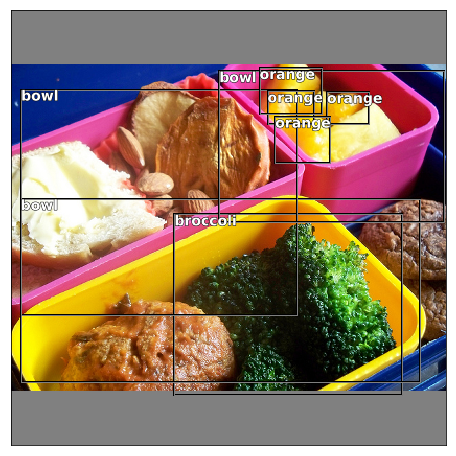

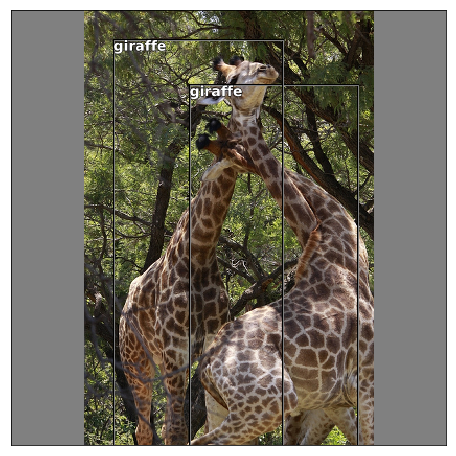

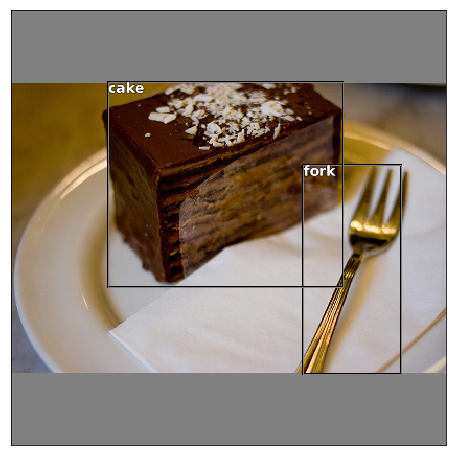

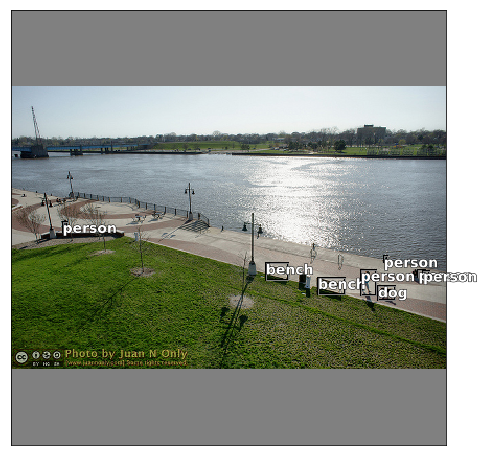

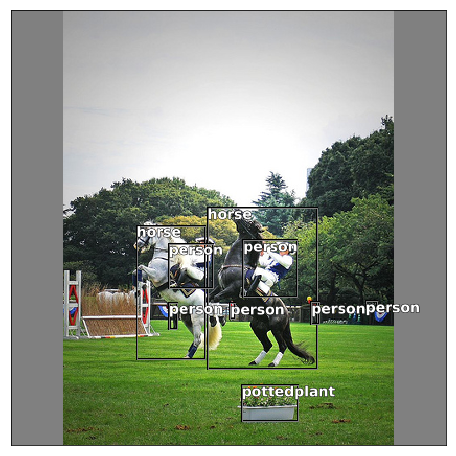

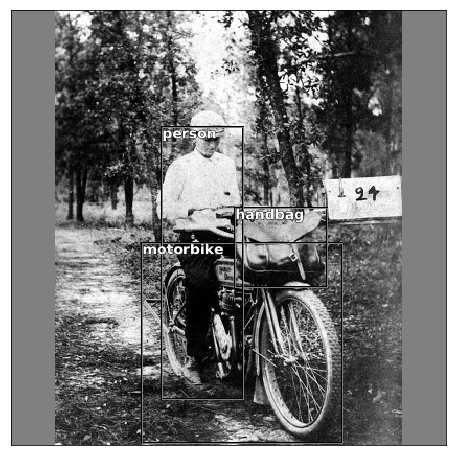

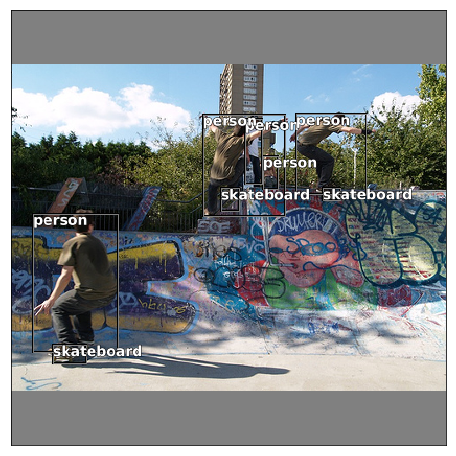

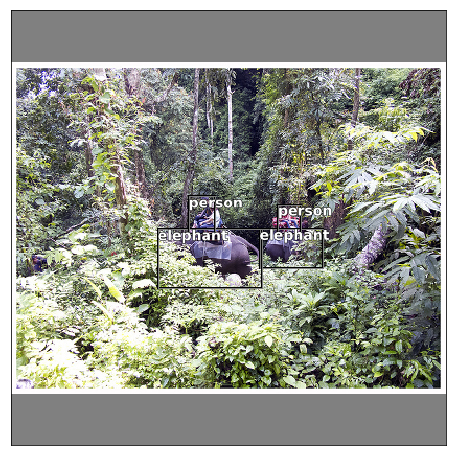

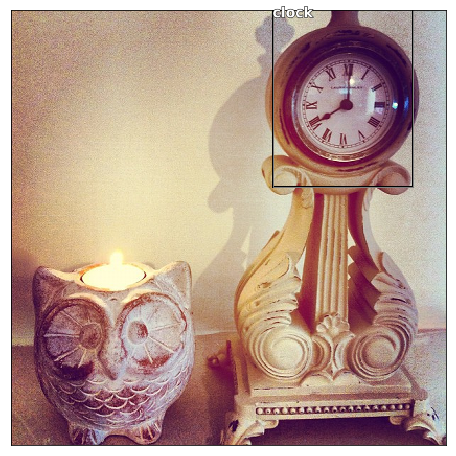

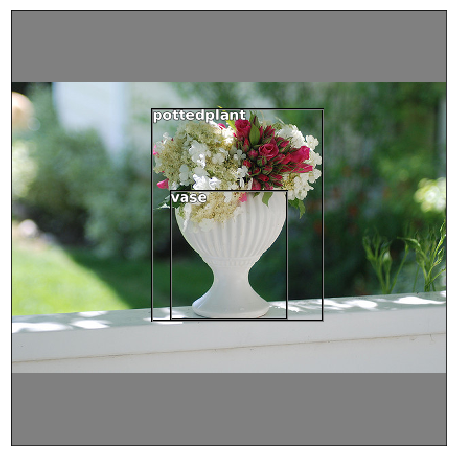

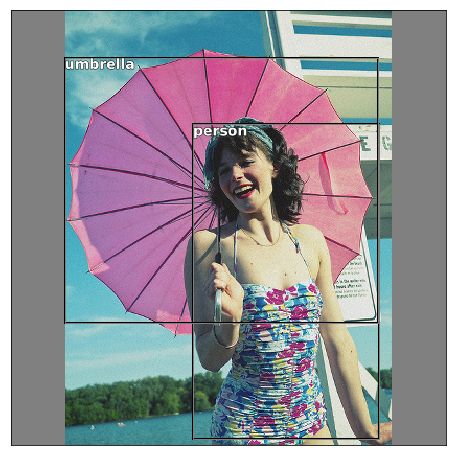

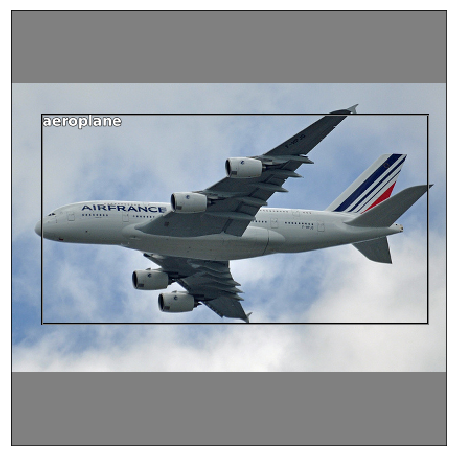

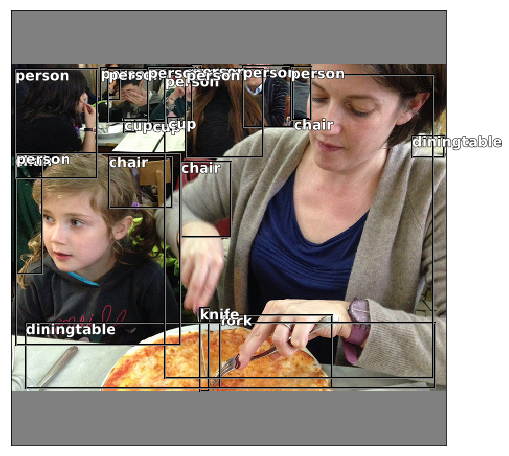

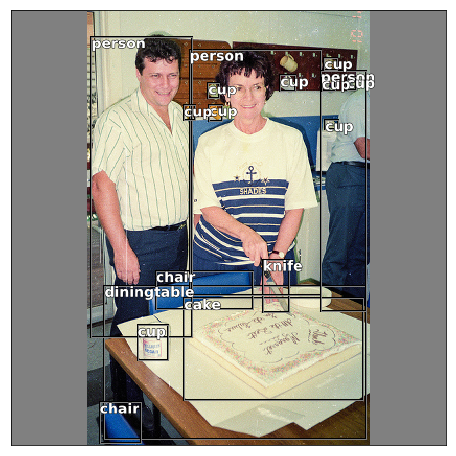

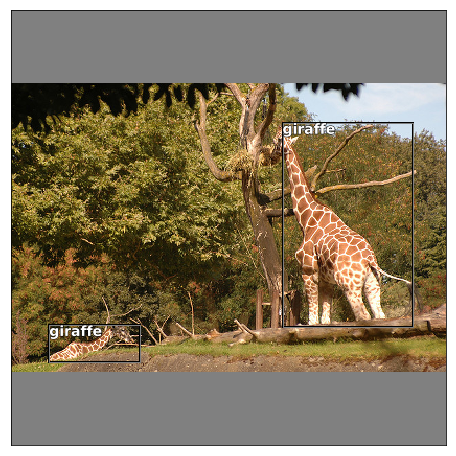

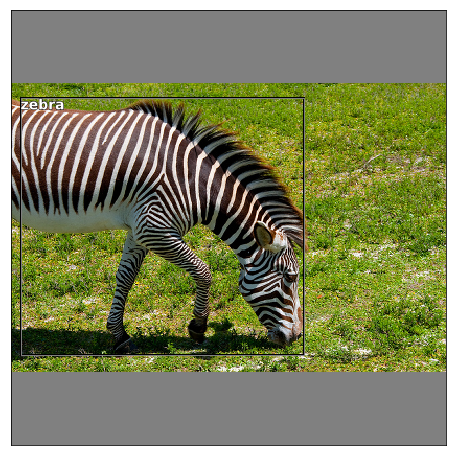

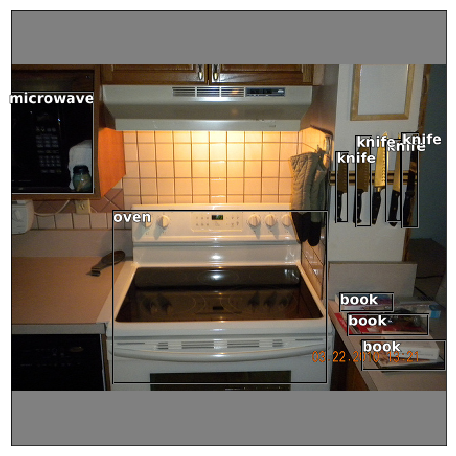

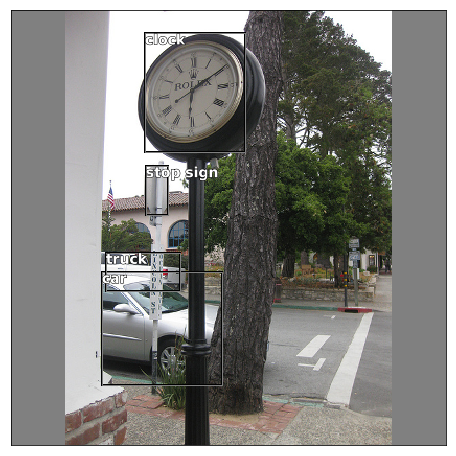

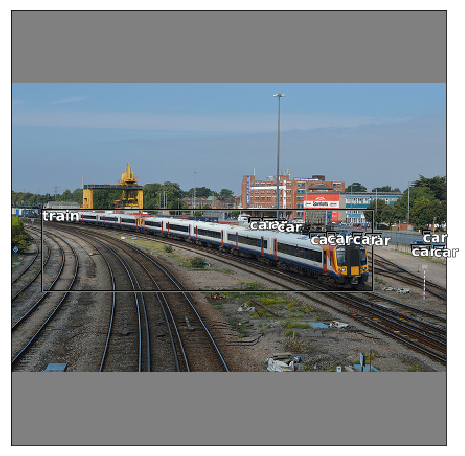

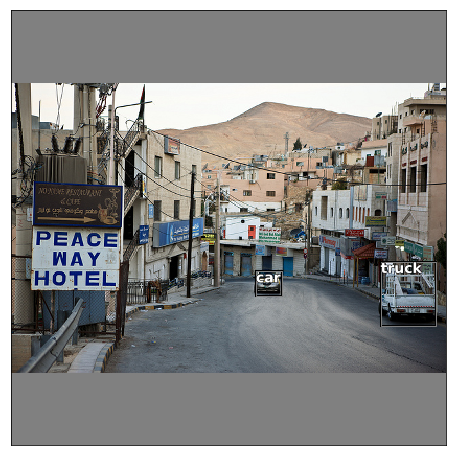

In [21]:
test_intermediate_model('quick_test')